In [1]:
# imports
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2, l1_l2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# get dataset
data = fetch_olivetti_faces(shuffle=True, random_state=42)

X = data.images.reshape(data.images.shape[0], - 1)
y = data.target

print("Images shape:", X.shape)
print("Labels shape:", y.shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Images shape: (400, 4096)
Labels shape: (400,)


In [3]:
# split data into 90% training and 10% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 360
Test set size: 40


In [4]:
# create and fit the pca instance / transform data
pca = PCA(n_components=0.99)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
X_train_reduced[0].shape

(242,)

In [5]:
def build_autoencoder(model_shape, top_size, code_size, learning_rate):
  regularizer = l2(0.00005)

  # create encoder
  stacked_encoder = Sequential()
  stacked_encoder.add(Flatten())  # input
  stacked_encoder.add(Dense(top_size, activation="relu", kernel_regularizer=regularizer))  # hidden 1
  stacked_encoder.add(Dense(code_size, activation="relu", kernel_regularizer=regularizer))  # code

  # create decoder
  stacked_decoder = Sequential()
  stacked_decoder.add(Dense(top_size, activation="relu", kernel_regularizer=regularizer))  # hidden 2
  stacked_decoder.add(Dense(model_shape, kernel_regularizer=regularizer))  # output

  # combine encoder and decoder
  autoencoder = Sequential()
  autoencoder.add(stacked_encoder)
  autoencoder.add(stacked_decoder)

  # compile model
  autoencoder.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate), loss="mse")

  return autoencoder

In [6]:
# define callbacks
es = EarlyStopping(monitor="val_loss", patience=5, verbose=0)

# define params for grid search
top_layer_size = [192, 160, 128]
code_layer_size = [64, 32, 16]
learning_rates = [0.001, 0.01, 0.1]

# best values init
best_model = None
best_loss = float("inf")
best_params = None

# add k-fold instance
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# gridsearch
for top_size in tqdm(top_layer_size):
  for code_size in code_layer_size:
    for lr in learning_rates:
      # create autoencoder instance
      autoencoder = build_autoencoder(X_train_reduced[0].shape[0], top_size, code_size, lr)

      # k-fold validation
      for train_index, val_index in kf.split(X_train_reduced):

        history = autoencoder.fit(X_train_reduced[train_index], X_train_reduced[train_index], validation_data=(X_train_reduced[val_index], X_train_reduced[val_index]), epochs=10000, batch_size=128, verbose=0, callbacks=[es])

      # check if parameters are better and save best values and instance
      val_loss = history.history["val_loss"][-1]

      if val_loss < best_loss:
          best_loss = val_loss
          best_model = autoencoder
          best_params = [top_size, code_size, lr]

100%|██████████| 3/3 [04:26<00:00, 88.99s/it]


In [7]:
print(f"Best loss:\t\t{best_loss}\nBest top layer size:\t{best_params[0]}\nBest code layer size:\t{best_params[1]}\nBest learning rate:\t{best_params[2]}")

Best loss:		0.04733353853225708
Best top layer size:	160
Best code layer size:	64
Best learning rate:	0.001


In [8]:
# evaluate the best model on the test set
test_loss = best_model.evaluate(X_test_reduced, X_test_reduced)
test_loss

2/2 [==============================] - 0s 6ms/step - loss: 0.0515


0.05151857063174248

In [9]:
# get some random samples from test set and predict
sample_indices = np.random.randint(0, X_test_reduced.shape[0], 5)
reconstructed_images = best_model.predict(X_test_reduced[sample_indices])

1/1 [==============================] - 0s 123ms/step


In [10]:
# calculate pca inverse
reconstructed_images = pca.inverse_transform(reconstructed_images)

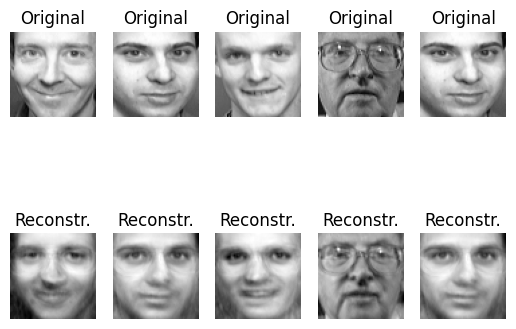

Test loss: 0.05151857063174248


In [11]:
# display original and reconstructed images for some test samples
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(64, 64), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 5, i + 6)
    plt.imshow(reconstructed_images[i].reshape(64, 64), cmap="gray")
    plt.title("Reconstr.")
    plt.axis("off")

plt.show()

# Report the test loss and other findings
print(f"Test loss: {test_loss}")